- cleaning 완료한 데이터는 news_cleaned.db에 저장함
- **2020.08.11 cleaning 업데이트 -> 같은 이름의 db에 다시 저장**
- 전처리 중간과정을 진행할 때는 import, 한글깨짐 부분 실행하고 바로 해당 전처리 부분으로 넘어가서 db 가져오면 됨

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import re
from konlpy.tag import Kkma, Hannanum, Komoran, Okt
from nltk import Text
import matplotlib.pyplot as plt
import matplotlib as mpl
from nltk.tokenize import sent_tokenize, regexp_tokenize
import seaborn as sns
from collections import Counter
import datetime
import ast
import pickle

In [2]:
# 한글깨짐 해결
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (14,4)

# 마이너스 깨짐 해결
mpl.rcParams['axes.unicode_minus'] = False

# Data Cleaning

## Data Load (raw)

In [9]:
conn = sqlite3.connect('../data/news_raw.db')
cur = conn.cursor()

In [10]:
query = cur.execute('SELECT * FROM navernews')
cols = [column[0] for column in query.description]
naver = pd.DataFrame.from_records(data=query.fetchall(), columns=cols)
naver.shape

(112466, 6)

In [11]:
query = cur.execute('SELECT * FROM daumnews')
cols = [column[0] for column in query.description]
daum = pd.DataFrame.from_records(data=query.fetchall(), columns=cols)
daum.shape

(109419, 6)

In [12]:
naver.head()

,id,title,date,body,summary,link
0,1,"이총리 ""폭염, 특별재난 준해…전기요금 제한적 특별배려 검토""",2018.07.31. 오전 11:53,"[연합뉴스TV 제공]국무회의 주재…체계적 폭염대책 주문""최저임금 명암…변화 수용하되...",이낙연 국무총리는 31일 계속되는 폭염으로 전기요금 부담에 대한 우려가 커지고 있는...,https://news.naver.com/main/ranking/read.nhn?r...
1,2,"김성태 ""盧 탄핵때도 기무사 대응문건 의혹…즉시 제출하라""",2018.07.31. 오전 10:25,"""文대통령, 여름휴가 때 노동자·소상공인 생각하길""김성태 자유한국당 원내대표. 뉴스...","김성태 자유한국당 원내대표는 31일 ""지난 2004년 노무현 전 대통령 탄핵 당시 ...",https://news.naver.com/main/ranking/read.nhn?r...
2,3,"합참, 北 ICBM 제작 정황 보도에 ""면밀히 추적·감시중""",2018.07.31. 오전 11:29,"노재천 공보실장 ""공식확인 부적절…한미간 공조""워싱턴포스트 ""액화연료 사용 ICBM...",합동참모본부는 31일 북한이 대륙간탄도미사일을 만들고 있는 정황을 포착했다는 보도와...,https://news.naver.com/main/ranking/read.nhn?r...
3,4,"기무사 ""盧 대통령 탄핵 당시 계엄검토 문건 작성 안해""",2018.07.31. 오후 2:43,김성태 의원 주장에 반박…지난 정부에서도 관련 내용 확인【과천=뉴시스】이영환 기자 ...,국군기무사령부는 31일 노무현 전 대통령 탄핵 당시 계엄령 문건을 작성했다는 김성태...,https://news.naver.com/main/ranking/read.nhn?r...
4,5,"'종전문제 다룰까' 北, 이례적 회담 제의 이어 전향적 태도 보여",2018.07.31. 오후 12:55,"안익산 대표 ""南 흔들어 종전선언? 보도, 그럴 수 있다"" 이해【파주=뉴시스】사진공...",북한이 이례적으로 남북 장성급 군사회담을 먼저 제의한데 이어 회담에서 전향적인 태도...,https://news.naver.com/main/ranking/read.nhn?r...


In [13]:
daum.head()

,id,title,date,body,summary,link
0,1,반복된 음식점 단속에 절망한 26살 청년의 '극단적 선택',2017.08.01. 09:00,"""벌금과 단속 걱정하던 아들, 장사 준비하던 현수막으로 목 메 숨져""결혼까지 미루고...",26살 황승우씨는 지난 30일 오전 경기 남양주시 조안면 막국수집 주방에서 목을 메...,https://v.daum.net/v/20170801090037914
1,2,'즉석만남에 술 한잔 했는데'..휴가철 성범죄 표적된 여성들,2017.08.01. 15:59,#1. 20대 여성 A씨는 지난해 7월 서해 한 해수욕장에 놀러갔다가 우연히 30대...,"본격적인 여름 휴가철을 맞아 해수욕장, 계곡과 같은 피서지에 인파가 몰리면서 성범죄...",https://v.daum.net/v/20170801155924346
2,3,"필리핀서 한국인 관광객 숨진채 발견..""카지노서 거액 잃어""",2017.08.01. 18:41,(하노이=연합뉴스) 김문성 특파원 = 필리핀에서 30대 한국인 관광객이 숨진 채 발...,필리핀에서 30대 한국인 관광객이 숨진 채 발견됐다.\n현지 경찰은 이 한국인이 카...,https://v.daum.net/v/20170801184128126
3,4,"""부인이 공관병 상대 갑질"" 논란 박찬주 육군대장 전역지원(종합)",2017.08.01. 18:50,\n(서울=연합뉴스) 김귀근 이영재 기자 = 공관병에 대한 부인의 '갑질' 의혹을 ...,공관병에 대한 부인의 '갑질' 의혹을 받고 있는 박찬주 육군 2작전사령관(대장)이 ...,https://v.daum.net/v/20170801185020317
4,5,화장실에 몰카 설치해 딸 친구 '찰칵' 목사 입건,2017.08.01. 07:45,(청주=연합뉴스) 이승민 기자 = 청주 흥덕경찰서는 화장실에 '몰래카메라'를 설치해...,경찰에 따르면 A씨는 지난달 29일 오후 3시 25분께 흥덕구의 자신의 집 화장실 ...,https://v.daum.net/v/20170801074552385


In [14]:
cur.close()
conn.close()

## body

In [198]:
naver_copy = naver.copy()
daum_copy = daum.copy()

In [196]:
def cleaning_body(row):
    '''
    1. 여러 개의 공백 하나로 줄이기
    2. 특수문자 대체
    3. 일부 특수 문자, 띄어쓰기, 영어, 한글 등을 제외하고 모두 제거 (ex. 한자)
    4. 언론사명, 기자명 제거
    5. 기자이메일, 각종 계정 제거
    6. 음성정보 제공용 텍스트 안내문구 제거
    '''
    
    # 1. 여러 개의 공백 하나로 줄이기
    result = re.sub(r'\s+',
                   ' ', row).strip()
    
    # 2. 특수문자 대체
    result = re.sub(r'＂', '"', result)
    result = re.sub(r'，', ',', result)
    result = re.sub(r'∙', '·', result)
    result = re.sub(r'½', '2분의 1', result)
    result = re.sub(r'‘”', '\'"', result)
    result = re.sub(r'㎜', 'mm', result)
    result = re.sub(r'㎢', '제곱킬로미터', result)
    result = re.sub(r'……', '··· ···', result)
    result = re.sub(r'’”', '\'"', result)
    result = re.sub(r'[○ㅇ]', 'ㅇ', result)
    result = re.sub(r'＊', '*', result)
    result = re.sub(r'⋯‘', "···'", result)
    result = re.sub(r'…', '···', result)
    result = re.sub(r'㎚', 'nm', result)
    result = re.sub(r'…’', "···'", result)
    result = re.sub(r'＆', '&', result)
    result = re.sub(r'“', '"', result)
    result = re.sub(r'”', '"', result).strip()
    
    # 3. 일부 특수문자(.,?!/@$%~％·∼()【】©), 띄어쓰기, ASCII 문자(\x00-\x7F), 한글(가-힣)) 제외하고 제거
    result = re.sub(r'[^ .,?!/@$%~％·∼()【】©\x00-\x7F가-힣]+',
                   '', result).strip()
    
    # 4. 언론사명, 기자명 제거
        # = 이 있는 경우
    result = re.sub(r'[\[\(【][가-힣A-Za-z0-9\s,\(\)/·!]+=[가-힣A-Za-z0-9\s,\(\)/·]+[\]\)】]\s?([가-힣A-Za-z\s]+=)*',
                   '', result).strip()
        # = 이 없는 경우 본문의 중요 정보가 사라지지 않도록 ()는 match에서 제외
    result = re.sub(r'[\[【][가-힣A-Za-z0-9\s,\(\)/·:|!]+[\]】]\s?([가-힣A-Za-z\s]+=)*',
                   '', result).strip()
    result = re.sub(r'[가-힣A-Za-z0-9\s,\(\)/·:|]*©[가-힣A-Za-z0-9\s,\(\)/·:|]+기자',
                   '', result).strip()
    result = re.sub(r'\(베스트 일레븐\)',
                   '', result).strip()
    
    # 5. 기자이메일, 각종 계정 제거
    result = re.sub(r'([A-Za-z가-힣]+\s?기자)?\s?[A-Za-z0-9]+@([A-Za-z0-9.]+\s*[A-Za-z가-힣 ]*)?',
                   '', result).strip()
    
    # 6. 음성정보 제공용 텍스트 안내문구 제거
    result = re.sub(r'<<[가-힣A-Za-z0-9 ]+>>',
                    '', result).strip()
    return result

In [199]:
n_body_cleaned = naver_copy.body.apply(cleaning_body)
d_body_cleaned = daum_copy.body.apply(cleaning_body)

In [200]:
naver_copy.body = n_body_cleaned
daum_copy.body = d_body_cleaned

body 없는 행 제거

In [201]:
n_blank_idx = []
for i in range(len(naver_copy)):
    if naver_copy.loc[i, 'body'] == '':
        n_blank_idx.append(i)
        
d_blank_idx = []
for i in range(len(daum_copy)):
    if daum_copy.loc[i, 'body'] == '':
        d_blank_idx.append(i)

len(n_blank_idx), len(d_blank_idx)

(12, 214)

In [202]:
print(naver_copy.shape)
naver_copy.drop(index=n_blank_idx, inplace=True)
print(naver_copy.shape)

(112466, 6)
(112454, 6)


In [203]:
print(daum_copy.shape)
daum_copy.drop(index=d_blank_idx, inplace=True)
print(daum_copy.shape)

(109419, 6)
(109205, 6)


## summary

In [197]:
def cleaning_summary(row):
    '''
    1. 여러 개의 공백 하나로 줄이기
    2. 특수문자 대체
    3. 일부 특수 문자, 띄어쓰기, 영어, 한글 등을 제외하고 모두 제거 (ex. 한자)
    '''
    # 1. 여러 개의 공백 하나로 줄이기
    result = re.sub(r'\s+',
                   ' ', row).strip()
    
    # 2. 특수문자 대체
    result = re.sub(r'＂', '"', result)
    result = re.sub(r'，', ',', result)
    result = re.sub(r'∙', '·', result)
    result = re.sub(r'½', '2분의 1', result)
    result = re.sub(r'‘”', '\'"', result)
    result = re.sub(r'㎜', 'mm', result)
    result = re.sub(r'㎢', '제곱킬로미터', result)
    result = re.sub(r'……', '··· ···', result)
    result = re.sub(r'’”', '\'"', result)
    result = re.sub(r'[○ㅇ]', 'ㅇ', result)
    result = re.sub(r'＊', '*', result)
    result = re.sub(r'⋯‘', "···'", result)
    result = re.sub(r'…', '···', result)
    result = re.sub(r'㎚', 'nm', result)
    result = re.sub(r'…’', "···'", result)
    result = re.sub(r'＆', '&', result)
    result = re.sub(r'“', '"', result)
    result = re.sub(r'”', '"', result).strip()
    
    # 3. 일부 특수문자(.,?!/@$%~％·∼()), 띄어쓰기, ASCII 문자(\x00-\x7F), 한글(가-힣)) 제외하고 제거
    result = re.sub(r'[^ .,?!/@$%~％·∼()\x00-\x7F가-힣]+',
                   '', result).strip()
    return result    

In [204]:
n_summ_cleaned = naver_copy.summary.apply(cleaning_summary)
d_summ_cleaned = daum_copy.summary.apply(cleaning_summary)

In [205]:
naver_copy.summary = n_summ_cleaned
daum_copy.summary = d_summ_cleaned

## DB에 저장 (cleaned)

In [210]:
conn = sqlite3.connect('../data/news_cleaned.db')
cur = conn.cursor()

In [211]:
naver_copy.to_sql('navernews', conn, index=False)
daum_copy.to_sql('daumnews', conn, index=False)

In [212]:
cur.close()
conn.close()

# Tokenizing & Lematization

## Data Load (cleaned)

In [15]:
conn = sqlite3.connect('../data/news_cleaned.db')
cur = conn.cursor()

In [4]:
query = cur.execute('SELECT * FROM navernews')
cols = [column[0] for column in query.description]
naver_cleaned = pd.DataFrame.from_records(data=query.fetchall(), columns=cols)
naver_cleaned.shape

(112454, 6)

In [16]:
query = cur.execute('SELECT * FROM daumnews')
cols = [column[0] for column in query.description]
daum_cleaned = pd.DataFrame.from_records(data=query.fetchall(), columns=cols)
daum_cleaned.shape

(109205, 6)

In [6]:
naver_cleaned.head()

,id,title,date,body,summary,link
0,1,"이총리 ""폭염, 특별재난 준해…전기요금 제한적 특별배려 검토""",2018.07.31. 오전 11:53,"국무회의 주재···체계적 폭염대책 주문""최저임금 명암···변화 수용하되 진통 최소화...",이낙연 국무총리는 31일 계속되는 폭염으로 전기요금 부담에 대한 우려가 커지고 있는...,https://news.naver.com/main/ranking/read.nhn?r...
1,2,"김성태 ""盧 탄핵때도 기무사 대응문건 의혹…즉시 제출하라""",2018.07.31. 오전 10:25,"""대통령, 여름휴가 때 노동자·소상공인 생각하길""김성태 자유한국당 원내대표. = 김...","김성태 자유한국당 원내대표는 31일 ""지난 2004년 노무현 전 대통령 탄핵 당시 ...",https://news.naver.com/main/ranking/read.nhn?r...
2,3,"합참, 北 ICBM 제작 정황 보도에 ""면밀히 추적·감시중""",2018.07.31. 오전 11:29,"노재천 공보실장 ""공식확인 부적절···한미간 공조""워싱턴포스트 ""액화연료 사용 IC...",합동참모본부는 31일 북한이 대륙간탄도미사일을 만들고 있는 정황을 포착했다는 보도와...,https://news.naver.com/main/ranking/read.nhn?r...
3,4,"기무사 ""盧 대통령 탄핵 당시 계엄검토 문건 작성 안해""",2018.07.31. 오후 2:43,김성태 의원 주장에 반박···지난 정부에서도 관련 내용 확인 국방부 특별수사단이 계...,국군기무사령부는 31일 노무현 전 대통령 탄핵 당시 계엄령 문건을 작성했다는 김성태...,https://news.naver.com/main/ranking/read.nhn?r...
4,5,"'종전문제 다룰까' 北, 이례적 회담 제의 이어 전향적 태도 보여",2018.07.31. 오후 12:55,"안익산 대표 "" 흔들어 종전선언? 보도, 그럴 수 있다"" 이해 안익산 북측 수석대표...",북한이 이례적으로 남북 장성급 군사회담을 먼저 제의한데 이어 회담에서 전향적인 태도...,https://news.naver.com/main/ranking/read.nhn?r...


In [17]:
daum_cleaned.head()

,id,title,date,body,summary,link
0,1,반복된 음식점 단속에 절망한 26살 청년의 '극단적 선택',2017.08.01. 09:00,"""벌금과 단속 걱정하던 아들, 장사 준비하던 현수막으로 목 메 숨져""결혼까지 미루고...",26살 황승우씨는 지난 30일 오전 경기 남양주시 조안면 막국수집 주방에서 목을 메...,https://v.daum.net/v/20170801090037914
1,2,'즉석만남에 술 한잔 했는데'..휴가철 성범죄 표적된 여성들,2017.08.01. 15:59,#1. 20대 여성 A씨는 지난해 7월 서해 한 해수욕장에 놀러갔다가 우연히 30대...,"본격적인 여름 휴가철을 맞아 해수욕장, 계곡과 같은 피서지에 인파가 몰리면서 성범죄...",https://v.daum.net/v/20170801155924346
2,3,"필리핀서 한국인 관광객 숨진채 발견..""카지노서 거액 잃어""",2017.08.01. 18:41,필리핀에서 30대 한국인 관광객이 숨진 채 발견됐다. 현지 경찰은 이 한국인이 카지...,필리핀에서 30대 한국인 관광객이 숨진 채 발견됐다. 현지 경찰은 이 한국인이 카지...,https://v.daum.net/v/20170801184128126
3,4,"""부인이 공관병 상대 갑질"" 논란 박찬주 육군대장 전역지원(종합)",2017.08.01. 18:50,공관병에 대한 부인의 '갑질' 의혹을 받고 있는 박찬주 육군 2작전사령관(대장)이 ...,공관병에 대한 부인의 '갑질' 의혹을 받고 있는 박찬주 육군 2작전사령관(대장)이 ...,https://v.daum.net/v/20170801185020317
4,5,화장실에 몰카 설치해 딸 친구 '찰칵' 목사 입건,2017.08.01. 07:45,청주 흥덕경찰서는 화장실에 '몰래카메라'를 설치해 한 집에 사는 딸의 친구를 촬영한...,경찰에 따르면 A씨는 지난달 29일 오후 3시 25분께 흥덕구의 자신의 집 화장실 ...,https://v.daum.net/v/20170801074552385


In [18]:
cur.close()
conn.close()

## 기사 본문에서 Summary 문장의 위치 찾기

In [11]:
naver_cleaned_copy = naver_cleaned.copy()
daum_cleaned_copy = daum_cleaned.copy()

In [221]:
summary_loc_in_body(daum_cleaned.loc[1])

[41, 69, 72]

In [8]:
def summary_loc_in_body(row):
    '''기사 본문에서 summary 문장들의 위치를 비율로 나타내는 함수'''
    
    body_sentences = []
    summary_sentences = []
    summary_loc_p = []
    
    for _ in re.split(r'[?!.\n]', row['body']):
        if _ != '':
            body_sentences.append(_.strip())     
    for _ in re.split(r'[?!.\n]', row['summary']):
        if _ != '':
            summary_sentences.append(_.strip())
    
    for idx, sentence in enumerate(body_sentences):
        if sentence in summary_sentences:
            summary_loc_p.append(round(100 * ((idx+1) / len(body_sentences))))
            
    return summary_loc_p

In [222]:
def loc_ok(row):
    '''summary 문장이 모두 본문에서 발견되는지 확인'''
    
    body_sentences = []
    summary_sentences = []
    summary_loc_p = []
    
    for _ in re.split(r'[?!.\n]', row['body']):
        if _ != '':
            body_sentences.append(_.strip())     
    for _ in re.split(r'[?!.\n]', row['summary']):
        if _ != '':
            summary_sentences.append(_.strip())
    
    for idx, sentence in enumerate(body_sentences):
        if sentence in summary_sentences:
            summary_loc_p.append(round(100 * ((idx+1) / len(body_sentences))))
    
    loc_ok = (len(summary_sentences) == len(summary_loc_p))
            
    return loc_ok

In [223]:
locok = daum_cleaned_copy.apply(loc_ok, axis=1)

In [226]:
locok.sum() / len(daum_cleaned_copy) # 65.3%가 본문 내 summary 위치를 정확하게 찾았고 나머지는 1~2건 차이

0.6528821940387345

In [227]:
locok_n = naver_cleaned_copy.apply(loc_ok, axis=1)

In [228]:
locok_n.sum() / len(naver_cleaned_copy) # 10%는 좀 문제가...

0.10852437441087022

In [229]:
daum_cleaned_copy['summary_loc'] = daum_cleaned_copy.apply(summary_loc_in_body, axis=1)

In [230]:
daum_cleaned_copy.summary_loc

0                     [12, 23, 46]
1                     [41, 69, 72]
2                     [17, 33, 67]
3                      [5, 11, 16]
4                    [50, 75, 100]
                    ...           
109200            [10, 40, 70, 80]
109201    [4, 21, 32, 36, 39, 100]
109202           [11, 56, 67, 100]
109203             [4, 8, 20, 100]
109204                 [9, 27, 55]
Name: summary_loc, Length: 109205, dtype: object

In [232]:
summary_loc_list = []
for _ in daum_cleaned_copy.summary_loc:
    summary_loc_list += _

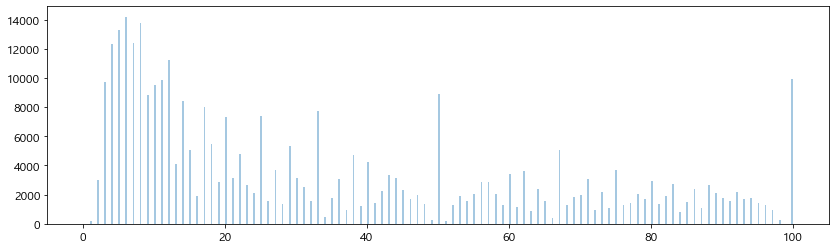

In [233]:
sns.distplot(summary_loc_list, bins=400, kde=False)

In [235]:
c = Counter(summary_loc_list)

In [239]:
c.most_common(20)

[(6, 14200),
 (8, 13765),
 (5, 13257),
 (7, 12399),
 (4, 12314),
 (12, 11222),
 (100, 9905),
 (11, 9879),
 (3, 9694),
 (10, 9501),
 (50, 8918),
 (9, 8852),
 (14, 8400),
 (17, 8025),
 (33, 7763),
 (25, 7359),
 (20, 7302),
 (18, 5478),
 (29, 5329),
 (67, 5067)]

## 형태소분석

In [7]:
han = Hannanum()

**naver**

In [28]:
# 앞에서부터 10만개 데이터로 한정
naver_cleaned_copy = naver_cleaned.iloc[:100000, :].copy()
naver_cleaned_copy.reset_index(inplace=True)
del naver_cleaned_copy['index']
print(naver_cleaned_copy.shape)
naver_cleaned_copy.head()

(100000, 6)


,id,title,date,body,summary,link
0,1,"이총리 ""폭염, 특별재난 준해…전기요금 제한적 특별배려 검토""",2018.07.31. 오전 11:53,"국무회의 주재···체계적 폭염대책 주문""최저임금 명암···변화 수용하되 진통 최소화...",이낙연 국무총리는 31일 계속되는 폭염으로 전기요금 부담에 대한 우려가 커지고 있는...,https://news.naver.com/main/ranking/read.nhn?r...
1,2,"김성태 ""盧 탄핵때도 기무사 대응문건 의혹…즉시 제출하라""",2018.07.31. 오전 10:25,"""대통령, 여름휴가 때 노동자·소상공인 생각하길""김성태 자유한국당 원내대표. = 김...","김성태 자유한국당 원내대표는 31일 ""지난 2004년 노무현 전 대통령 탄핵 당시 ...",https://news.naver.com/main/ranking/read.nhn?r...
2,3,"합참, 北 ICBM 제작 정황 보도에 ""면밀히 추적·감시중""",2018.07.31. 오전 11:29,"노재천 공보실장 ""공식확인 부적절···한미간 공조""워싱턴포스트 ""액화연료 사용 IC...",합동참모본부는 31일 북한이 대륙간탄도미사일을 만들고 있는 정황을 포착했다는 보도와...,https://news.naver.com/main/ranking/read.nhn?r...
3,4,"기무사 ""盧 대통령 탄핵 당시 계엄검토 문건 작성 안해""",2018.07.31. 오후 2:43,김성태 의원 주장에 반박···지난 정부에서도 관련 내용 확인 국방부 특별수사단이 계...,국군기무사령부는 31일 노무현 전 대통령 탄핵 당시 계엄령 문건을 작성했다는 김성태...,https://news.naver.com/main/ranking/read.nhn?r...
4,5,"'종전문제 다룰까' 北, 이례적 회담 제의 이어 전향적 태도 보여",2018.07.31. 오후 12:55,"안익산 대표 "" 흔들어 종전선언? 보도, 그럴 수 있다"" 이해 안익산 북측 수석대표...",북한이 이례적으로 남북 장성급 군사회담을 먼저 제의한데 이어 회담에서 전향적인 태도...,https://news.naver.com/main/ranking/read.nhn?r...


In [23]:
def get_morphs_body(row):
    morphs_list = han.morphs(row['body'])
    if row['id'] % 10000 == 0:
        print('{0} id {1} is processed'.format(datetime.datetime.now(), row['id']))
    return morphs_list

In [30]:
naver_cleaned_copy['body_morphs'] = naver_cleaned_copy.apply(get_morphs_body, axis=1)

2020-08-16 00:56:59.592441 id 10000 is processed
2020-08-16 01:16:51.642888 id 20000 is processed
2020-08-16 01:40:13.594638 id 30000 is processed
2020-08-16 02:04:55.969914 id 40000 is processed
2020-08-16 02:31:33.842516 id 50000 is processed
2020-08-16 02:59:32.834241 id 60000 is processed
2020-08-16 03:31:04.665996 id 70000 is processed
2020-08-16 04:05:54.752962 id 80000 is processed
2020-08-16 04:45:22.669260 id 90000 is processed
2020-08-17 06:32:30.562788 id 100000 is processed


In [129]:
test = naver_cleaned_copy.copy()

In [130]:
for i in range(len(test)):
    if test.loc[i,'body_morphs'] == []:
        print(i)

51815
61153
61160


In [152]:
new_body_morphs = test[['body_morphs']].drop(index=[51815, 61153, 61160]).reset_index()
del new_body_morphs['index']
print(new_body_morphs.shape)
new_body_morphs

(99997, 1)


,body_morphs
0,"[국무회의, 주재···체계적, 폭염대책, 주문, "", 최저임금, 명암···변화, 수..."
1,"["", 대통령, ,, 여름휴가, 때, 노동자·소상공, 이, ㄴ, 생각하길""김성태, ..."
2,"[노재천, 공보실장, "", 공식확인, 부적절···한미간, 공조""워싱턴포스트, "", ..."
3,"[김성태, 의원, 주장, 에, 반박···지난, 정부, 에서도, 관련, 내용, 확인,..."
4,"[안익산, 대표, "", 흔들, 어, 종전선언, ?, 보도, ,, 그렇, 을, 수, ..."
...,...
99992,"[음식, 을, 먼저, 받, 고, 다음, 에, 결제, 를, 하, 겠다, 고, 제안, ..."
99993,"[철거왕, 이금열(51)씨, 를, 알, 시나, 요, ., 조직폭력배, 이, 었던, ..."
99994,"[<32>홍현희, 의, 양치, 다이어트, 최근, 개그맨, 홍현희, 에, 관심, 이,..."
99995,"[밀, ㄴ, 식, 이, 부모, ,, 유튜버, 상대, 허위사실, 유포, 명예훼손, 등..."


In [133]:
missing_df = naver_cleaned.iloc[99997:100000]
missing_df

,id,title,date,body,summary,link
99997,100007,“포르쉐로 폼 잡지 마”…‘3000만원대 슈퍼카’ 벨로스터N,2020.05.16. 오후 3:54,"도로 위 악동()이 있다. 작은 악마라는 애칭도 있다. 남자의 로망이라는 페라리, ...","'남자의 로망'이라는 페라리, 람보르기니, 포르쉐 등이 만든 '폼생폼사' 슈퍼카나 ...",https://news.naver.com/main/ranking/read.nhn?r...
99998,100008,커피는 건강에 좋다? 지나치면 골관절염·비만 위험 키운다,2020.05.16. 오전 11:09,"1천117개 질병 증상과 커피 소비 연관성, 첫 유전적 분석 사우스오스트레일리아대 ...","커피는 가장 많이 소비되는 음료 가운데 하나다.휘페넨 교수는 ""종전의 연구에선 커피...",https://news.naver.com/main/ranking/read.nhn?r...
99999,100009,“어딜 만져!” 보안요원 뺨 때리고 콜라 뿌린 백화점 난동女 결국…,2020.05.15. 오전 10:50,"신병 확보 어려움 겪던 경찰, 지명수배 내린 이틀 만에 안양서 검거 올 초 서울의 ...",올 초 서울의 한 백화점 패스트푸드 코너에서 보안요원에 욕설하고 뺨까지 때린 여성이...,https://news.naver.com/main/ranking/read.nhn?r...


In [135]:
missing_morphs = missing_df.apply(get_morphs_body, axis=1)
missing_morphs

99997    [도, 로, 위, 악동(), 이, 있, 다, ., 작, 은, 악마, 라는, 애칭, ...
99998    [1천117개, 질병, 증상, 과, 커피, 소비, 연관성, ,, 첫, 유전적, 분석...
99999    [신병, 확보, 어려움, 겪, 던, 경찰, ,, 지명수배, 내리, ㄴ, 이틀, 만,...
dtype: object

In [149]:
missing_morphs = pd.DataFrame(missing_morphs).reset_index()
missing_morphs

,index,0
0,99997,"[도, 로, 위, 악동(), 이, 있, 다, ., 작, 은, 악마, 라는, 애칭, ..."
1,99998,"[1천117개, 질병, 증상, 과, 커피, 소비, 연관성, ,, 첫, 유전적, 분석..."
2,99999,"[신병, 확보, 어려움, 겪, 던, 경찰, ,, 지명수배, 내리, ㄴ, 이틀, 만,..."


In [151]:
# del missing_morphs['index']
missing_morphs.rename(columns={0:'body_morphs'}, inplace=True)
missing_morphs

,body_morphs
0,"[도, 로, 위, 악동(), 이, 있, 다, ., 작, 은, 악마, 라는, 애칭, ..."
1,"[1천117개, 질병, 증상, 과, 커피, 소비, 연관성, ,, 첫, 유전적, 분석..."
2,"[신병, 확보, 어려움, 겪, 던, 경찰, ,, 지명수배, 내리, ㄴ, 이틀, 만,..."


In [153]:
new_body_morphs = pd.concat([new_body_morphs, missing_morphs], ignore_index=True)
new_body_morphs

,body_morphs
0,"[국무회의, 주재···체계적, 폭염대책, 주문, "", 최저임금, 명암···변화, 수..."
1,"["", 대통령, ,, 여름휴가, 때, 노동자·소상공, 이, ㄴ, 생각하길""김성태, ..."
2,"[노재천, 공보실장, "", 공식확인, 부적절···한미간, 공조""워싱턴포스트, "", ..."
3,"[김성태, 의원, 주장, 에, 반박···지난, 정부, 에서도, 관련, 내용, 확인,..."
4,"[안익산, 대표, "", 흔들, 어, 종전선언, ?, 보도, ,, 그렇, 을, 수, ..."
...,...
99995,"[밀, ㄴ, 식, 이, 부모, ,, 유튜버, 상대, 허위사실, 유포, 명예훼손, 등..."
99996,"[사진, 과, 기사, 는, 관련, 없음, =게티이미지뱅크직업, 에, 귀천, 이, 없..."
99997,"[도, 로, 위, 악동(), 이, 있, 다, ., 작, 은, 악마, 라는, 애칭, ..."
99998,"[1천117개, 질병, 증상, 과, 커피, 소비, 연관성, ,, 첫, 유전적, 분석..."


In [155]:
del test['body_morphs']
test = pd.concat([test, new_body_morphs], axis=1)
test

,id,title,date,body,summary,link,body_morphs
0,1,"이총리 ""폭염, 특별재난 준해…전기요금 제한적 특별배려 검토""",2018.07.31. 오전 11:53,"국무회의 주재···체계적 폭염대책 주문""최저임금 명암···변화 수용하되 진통 최소화...",이낙연 국무총리는 31일 계속되는 폭염으로 전기요금 부담에 대한 우려가 커지고 있는...,https://news.naver.com/main/ranking/read.nhn?r...,"[국무회의, 주재···체계적, 폭염대책, 주문, "", 최저임금, 명암···변화, 수..."
1,2,"김성태 ""盧 탄핵때도 기무사 대응문건 의혹…즉시 제출하라""",2018.07.31. 오전 10:25,"""대통령, 여름휴가 때 노동자·소상공인 생각하길""김성태 자유한국당 원내대표. = 김...","김성태 자유한국당 원내대표는 31일 ""지난 2004년 노무현 전 대통령 탄핵 당시 ...",https://news.naver.com/main/ranking/read.nhn?r...,"["", 대통령, ,, 여름휴가, 때, 노동자·소상공, 이, ㄴ, 생각하길""김성태, ..."
2,3,"합참, 北 ICBM 제작 정황 보도에 ""면밀히 추적·감시중""",2018.07.31. 오전 11:29,"노재천 공보실장 ""공식확인 부적절···한미간 공조""워싱턴포스트 ""액화연료 사용 IC...",합동참모본부는 31일 북한이 대륙간탄도미사일을 만들고 있는 정황을 포착했다는 보도와...,https://news.naver.com/main/ranking/read.nhn?r...,"[노재천, 공보실장, "", 공식확인, 부적절···한미간, 공조""워싱턴포스트, "", ..."
3,4,"기무사 ""盧 대통령 탄핵 당시 계엄검토 문건 작성 안해""",2018.07.31. 오후 2:43,김성태 의원 주장에 반박···지난 정부에서도 관련 내용 확인 국방부 특별수사단이 계...,국군기무사령부는 31일 노무현 전 대통령 탄핵 당시 계엄령 문건을 작성했다는 김성태...,https://news.naver.com/main/ranking/read.nhn?r...,"[김성태, 의원, 주장, 에, 반박···지난, 정부, 에서도, 관련, 내용, 확인,..."
4,5,"'종전문제 다룰까' 北, 이례적 회담 제의 이어 전향적 태도 보여",2018.07.31. 오후 12:55,"안익산 대표 "" 흔들어 종전선언? 보도, 그럴 수 있다"" 이해 안익산 북측 수석대표...",북한이 이례적으로 남북 장성급 군사회담을 먼저 제의한데 이어 회담에서 전향적인 태도...,https://news.naver.com/main/ranking/read.nhn?r...,"[안익산, 대표, "", 흔들, 어, 종전선언, ?, 보도, ,, 그렇, 을, 수, ..."
...,...,...,...,...,...,...,...
99995,100005,유튜버가 민식이 부모에게 “불쾌하다”고 한 이유… 7억 사망보험금 논란,2020.05.16. 오전 7:02,"민식이 부모, 유튜버 상대 허위사실 유포 명예훼손 등 고소 / 유튜버 ""사실적시 명...",일명 '민식이법'으로 불리는 도로교통법 개정안 통과를 이끌어낸 고 김민식군의 부모가...,https://news.naver.com/main/ranking/read.nhn?r...,"[밀, ㄴ, 식, 이, 부모, ,, 유튜버, 상대, 허위사실, 유포, 명예훼손, 등..."
99996,100006,"""예비 시어머니가 접대부 있는 유흥업소를 운영하신대요"" [와글와글]",2020.05.16. 오전 8:32,"사진과 기사는 관련 없음/사진=게티이미지뱅크직업에 귀천이 없다지만, 예비 시어머니가...","직업에 귀천이 없다지만, 예비 시어머니가 접대부를 고용한 유흥업소를 운영한다는 말을...",https://news.naver.com/main/ranking/read.nhn?r...,"[사진, 과, 기사, 는, 관련, 없음, =게티이미지뱅크직업, 에, 귀천, 이, 없..."
99997,100007,“포르쉐로 폼 잡지 마”…‘3000만원대 슈퍼카’ 벨로스터N,2020.05.16. 오후 3:54,"도로 위 악동()이 있다. 작은 악마라는 애칭도 있다. 남자의 로망이라는 페라리, ...","'남자의 로망'이라는 페라리, 람보르기니, 포르쉐 등이 만든 '폼생폼사' 슈퍼카나 ...",https://news.naver.com/main/ranking/read.nhn?r...,"[도, 로, 위, 악동(), 이, 있, 다, ., 작, 은, 악마, 라는, 애칭, ..."
99998,100008,커피는 건강에 좋다? 지나치면 골관절염·비만 위험 키운다,2020.05.16. 오전 11:09,"1천117개 질병 증상과 커피 소비 연관성, 첫 유전적 분석 사우스오스트레일리아대 ...","커피는 가장 많이 소비되는 음료 가운데 하나다.휘페넨 교수는 ""종전의 연구에선 커피...",https://news.naver.com/main/ranking/read.nhn?r...,"[1천117개, 질병, 증상, 과, 커피, 소비, 연관성, ,, 첫, 유전적, 분석..."


In [156]:
test.to_csv('../data/in_progress.csv', header=True, index=False)

In [3]:
naver_tokenized = pd.read_csv('../data/in_progress.csv')
naver_tokenized.shape

(100000, 7)

In [4]:
naver_tokenized.head(1)

,id,title,date,body,summary,link,body_morphs
0,1,"이총리 ""폭염, 특별재난 준해…전기요금 제한적 특별배려 검토""",2018.07.31. 오전 11:53,"국무회의 주재···체계적 폭염대책 주문""최저임금 명암···변화 수용하되 진통 최소화...",이낙연 국무총리는 31일 계속되는 폭염으로 전기요금 부담에 대한 우려가 커지고 있는...,https://news.naver.com/main/ranking/read.nhn?r...,"['국무회의', '주재···체계적', '폭염대책', '주문', '""', '최저임금'..."


In [24]:
def get_morphs_summary(row):
    morphs_list = han.morphs(row['summary'])
    if row['id'] % 10000 == 0:
        print('{0} id {1} is processed'.format(datetime.datetime.now(), row['id']))
    return morphs_list

2020-08-17 11:53 시작

In [8]:
naver_tokenized['summary_morphs'] = naver_tokenized.apply(get_morphs_summary, axis=1)

2020-08-17 11:55:36.385323 id 10000 is processed
2020-08-17 11:57:53.395032 id 20000 is processed
2020-08-17 12:00:14.072971 id 30000 is processed
2020-08-17 12:02:40.927398 id 40000 is processed
2020-08-17 12:05:11.281475 id 50000 is processed
2020-08-17 12:07:43.877554 id 60000 is processed
2020-08-17 12:10:57.375296 id 70000 is processed
2020-08-17 12:13:31.170172 id 80000 is processed
2020-08-17 12:16:09.792142 id 90000 is processed
2020-08-17 12:18:51.432048 id 100000 is processed


In [12]:
naver_tokenized.tail(3)

,id,title,date,body,summary,link,body_morphs,summary_morphs
99997,100007,“포르쉐로 폼 잡지 마”…‘3000만원대 슈퍼카’ 벨로스터N,2020.05.16. 오후 3:54,"도로 위 악동()이 있다. 작은 악마라는 애칭도 있다. 남자의 로망이라는 페라리, ...","'남자의 로망'이라는 페라리, 람보르기니, 포르쉐 등이 만든 '폼생폼사' 슈퍼카나 ...",https://news.naver.com/main/ranking/read.nhn?r...,"['도', '로', '위', '악동()', '이', '있', '다', '.', '작...","[', 남자, 의, 로망, ', 이, 라는, 페라리,, 람보르기니,, 포르쉐, 등,..."
99998,100008,커피는 건강에 좋다? 지나치면 골관절염·비만 위험 키운다,2020.05.16. 오전 11:09,"1천117개 질병 증상과 커피 소비 연관성, 첫 유전적 분석 사우스오스트레일리아대 ...","커피는 가장 많이 소비되는 음료 가운데 하나다.휘페넨 교수는 ""종전의 연구에선 커피...",https://news.naver.com/main/ranking/read.nhn?r...,"['1천117개', '질병', '증상', '과', '커피', '소비', '연관성',...","[커피, 는, 가장, 많, 이, 소비, 되, 는, 음료, 가운데, 하, 어, 나, ..."
99999,100009,“어딜 만져!” 보안요원 뺨 때리고 콜라 뿌린 백화점 난동女 결국…,2020.05.15. 오전 10:50,"신병 확보 어려움 겪던 경찰, 지명수배 내린 이틀 만에 안양서 검거 올 초 서울의 ...",올 초 서울의 한 백화점 패스트푸드 코너에서 보안요원에 욕설하고 뺨까지 때린 여성이...,https://news.naver.com/main/ranking/read.nhn?r...,"['신병', '확보', '어려움', '겪', '던', '경찰', ',', '지명수배...","[오, ㄹ, 초, 서울, 의, 한, 백화점, 패스트푸드, 코너, 에서, 보안요원, ..."


In [13]:
naver_tokenized.to_csv('../data/in_progress.csv', header=True, index=False)

**daum**

In [21]:
# 앞에서부터 10만개 데이터로 한정
daum_cleaned_copy = daum_cleaned.iloc[:100000, :].copy()
daum_cleaned_copy.reset_index(inplace=True)
del daum_cleaned_copy['index']
print(daum_cleaned_copy.shape)
daum_cleaned_copy.head()

(100000, 6)


,id,title,date,body,summary,link
0,1,반복된 음식점 단속에 절망한 26살 청년의 '극단적 선택',2017.08.01. 09:00,"""벌금과 단속 걱정하던 아들, 장사 준비하던 현수막으로 목 메 숨져""결혼까지 미루고...",26살 황승우씨는 지난 30일 오전 경기 남양주시 조안면 막국수집 주방에서 목을 메...,https://v.daum.net/v/20170801090037914
1,2,'즉석만남에 술 한잔 했는데'..휴가철 성범죄 표적된 여성들,2017.08.01. 15:59,#1. 20대 여성 A씨는 지난해 7월 서해 한 해수욕장에 놀러갔다가 우연히 30대...,"본격적인 여름 휴가철을 맞아 해수욕장, 계곡과 같은 피서지에 인파가 몰리면서 성범죄...",https://v.daum.net/v/20170801155924346
2,3,"필리핀서 한국인 관광객 숨진채 발견..""카지노서 거액 잃어""",2017.08.01. 18:41,필리핀에서 30대 한국인 관광객이 숨진 채 발견됐다. 현지 경찰은 이 한국인이 카지...,필리핀에서 30대 한국인 관광객이 숨진 채 발견됐다. 현지 경찰은 이 한국인이 카지...,https://v.daum.net/v/20170801184128126
3,4,"""부인이 공관병 상대 갑질"" 논란 박찬주 육군대장 전역지원(종합)",2017.08.01. 18:50,공관병에 대한 부인의 '갑질' 의혹을 받고 있는 박찬주 육군 2작전사령관(대장)이 ...,공관병에 대한 부인의 '갑질' 의혹을 받고 있는 박찬주 육군 2작전사령관(대장)이 ...,https://v.daum.net/v/20170801185020317
4,5,화장실에 몰카 설치해 딸 친구 '찰칵' 목사 입건,2017.08.01. 07:45,청주 흥덕경찰서는 화장실에 '몰래카메라'를 설치해 한 집에 사는 딸의 친구를 촬영한...,경찰에 따르면 A씨는 지난달 29일 오후 3시 25분께 흥덕구의 자신의 집 화장실 ...,https://v.daum.net/v/20170801074552385


2020-08-17 12:35 시작

In [27]:
daum_cleaned_copy['body_morphs'] = daum_cleaned_copy.apply(get_morphs_body, axis=1)

2020-08-17 12:46:57.893989 id 10000 is processed
2020-08-17 12:58:27.586303 id 20000 is processed
2020-08-17 13:10:44.620064 id 30000 is processed
2020-08-17 13:23:54.141517 id 40000 is processed
2020-08-17 13:38:05.372953 id 50000 is processed
2020-08-17 13:52:47.877843 id 60000 is processed
2020-08-17 14:07:57.975969 id 70000 is processed
2020-08-17 14:24:14.155447 id 80000 is processed
2020-08-17 14:40:56.507959 id 90000 is processed
2020-08-17 14:58:35.861097 id 100000 is processed


2020-08-17 15:32 시작

In [29]:
daum_cleaned_copy['summary_morphs'] = daum_cleaned_copy.apply(get_morphs_summary, axis=1)

2020-08-17 15:37:17.345306 id 10000 is processed
2020-08-17 15:41:30.233287 id 20000 is processed
2020-08-17 15:45:44.670126 id 30000 is processed
2020-08-17 15:50:01.306088 id 40000 is processed
2020-08-17 15:54:18.029849 id 50000 is processed
2020-08-17 15:58:54.445897 id 60000 is processed
2020-08-17 16:03:30.262586 id 70000 is processed
2020-08-17 16:08:23.488734 id 80000 is processed
2020-08-17 16:13:21.110131 id 90000 is processed
2020-08-17 16:18:22.951250 id 100000 is processed


In [31]:
daum_cleaned_copy

,id,title,date,body,summary,link,body_morphs,summary_morphs
0,1,반복된 음식점 단속에 절망한 26살 청년의 '극단적 선택',2017.08.01. 09:00,"""벌금과 단속 걱정하던 아들, 장사 준비하던 현수막으로 목 메 숨져""결혼까지 미루고...",26살 황승우씨는 지난 30일 오전 경기 남양주시 조안면 막국수집 주방에서 목을 메...,https://v.daum.net/v/20170801090037914,"["", 벌금, 과, 단속, 걱정, 하, 던, 아들, ,, 장사, 준비, 하, 던, ...","[26살, 황승우씨, 는, 지나, ㄴ, 30일, 오전, 경기, 남양주시, 조안면, ..."
1,2,'즉석만남에 술 한잔 했는데'..휴가철 성범죄 표적된 여성들,2017.08.01. 15:59,#1. 20대 여성 A씨는 지난해 7월 서해 한 해수욕장에 놀러갔다가 우연히 30대...,"본격적인 여름 휴가철을 맞아 해수욕장, 계곡과 같은 피서지에 인파가 몰리면서 성범죄...",https://v.daum.net/v/20170801155924346,"[#1, ., 20대, 여성, A, 씨, 는, 지난해, 7월, 서, 어, 하, 어,...","[본격적, 이, ㄴ, 여름, 휴가철, 을, 맞, 아, 해수욕장, ,, 계곡, 과, ..."
2,3,"필리핀서 한국인 관광객 숨진채 발견..""카지노서 거액 잃어""",2017.08.01. 18:41,필리핀에서 30대 한국인 관광객이 숨진 채 발견됐다. 현지 경찰은 이 한국인이 카지...,필리핀에서 30대 한국인 관광객이 숨진 채 발견됐다. 현지 경찰은 이 한국인이 카지...,https://v.daum.net/v/20170801184128126,"[필리핀, 에서, 30대, 한국인, 관광객, 이, 숨지, ㄴ, 채, 발견, 되, 었...","[필리핀, 에서, 30대, 한국인, 관광객, 이, 숨지, ㄴ, 채, 발견, 되, 었..."
3,4,"""부인이 공관병 상대 갑질"" 논란 박찬주 육군대장 전역지원(종합)",2017.08.01. 18:50,공관병에 대한 부인의 '갑질' 의혹을 받고 있는 박찬주 육군 2작전사령관(대장)이 ...,공관병에 대한 부인의 '갑질' 의혹을 받고 있는 박찬주 육군 2작전사령관(대장)이 ...,https://v.daum.net/v/20170801185020317,"[공관병, 에, 대하, ㄴ, 부인, 의, '갑질', 의혹, 을, 받, 고, 있, 는...","[공관병, 에, 대하, ㄴ, 부인, 의, '갑질', 의혹, 을, 받, 고, 있, 는..."
4,5,화장실에 몰카 설치해 딸 친구 '찰칵' 목사 입건,2017.08.01. 07:45,청주 흥덕경찰서는 화장실에 '몰래카메라'를 설치해 한 집에 사는 딸의 친구를 촬영한...,경찰에 따르면 A씨는 지난달 29일 오후 3시 25분께 흥덕구의 자신의 집 화장실 ...,https://v.daum.net/v/20170801074552385,"[청주, 흥덕경찰서, 는, 화장실, 에, ', 몰래카메라, ', 를, 설치, 하, ...","[경찰, 에, 따르, 면, A, 씨, 는, 지난달, 29일, 오후, 3시, 25분,..."
...,...,...,...,...,...,...,...,...
99995,100219,"용인 확진 남성, 클럽·식당 등 잇따라 방문..""집단감염 우려""",2020.05.07. 12:12,전국에서 사흘 만에 첫 지역사회 감염자로 판정된 경기 용인시 거주 29세 남성 A씨...,전국에서 사흘 만에 첫 지역사회 감염자로 판정된 경기 용인시 거주 29세 남성 A씨...,https://v.daum.net/v/20200507121209139,"[전국, 에서, 사흘, 만, 에, 첫, 지역사회, 감염자, 로, 판정, 되, ㄴ, ...","[전국, 에서, 사흘, 만, 에, 첫, 지역사회, 감염자, 로, 판정, 되, ㄴ, ..."
99996,100220,재난지원금 궁금증 10가지 '동네병원 되고 백화점 안돼요',2020.05.07. 05:06,"대학병원에서는 안되지만 약국에선 사용 가능?, 그럼 마트에서는? 사상 최초로 전 국...",사상 최초로 전 국민을 상대로 한 가구당 최대 100만원 긴급 재난지원금 지급이 본...,https://v.daum.net/v/20200507050603478,"[대학병원, 에서는, 안되, 지, 말, ㄴ, 약국, 에선, 사용, 가능, ?, ,,...","[사상, 최초, 로, 전, 국민, 을, 상대, 로, 하, ㄴ, 가구당, 최대, 10..."
99997,100221,"나흘만에 지역감염 발생 '긴장'..""코로나19 '은밀한 전파' 우려""",2020.05.07. 06:00,나흘 만에 국내 지역사회에서 신종 코로나바이러스 감염증(코로나19) 확진자가 나오면...,나흘 만에 국내 지역사회에서 신종 코로나바이러스 감염증(코로나19) 확진자가 나오면...,https://v.daum.net/v/20200507060022032,"[나흘, 만, 에, 국내, 지역사회, 에서, 신종, 코로나바이러스, 감염증(코로나1...","[나흘, 만, 에, 국내, 지역사회, 에서, 신종, 코로나바이러스, 감염증(코로나1..."
99998,100222,동네마트 양배추·두부값이..재난지원금의 역설,2020.05.07. 09:50,"""요새 '집콕'이라 라면 뽀사먹는 재미에 사는데 재난지원금으로 사려고 집 앞 마트에...","""요새 '집콕'이라 라면 뽀사먹는 재미에 사는데 재난지원금으로 사려고 집 앞 마트에...",https://v.daum.net/v/20200507095048101,"["", 요새, '집콕', 이, 라, 라, 이, 면, 뽀사먹, 는, 재미, 에, 사,...","["", 요새, '집콕', 이, 라, 라, 이, 면, 뽀사먹, 는, 재미, 에, 사,..."


## Naver + Daum

In [49]:
naver_tokenized['site'] = 'naver'
daum_cleaned_copy['site'] = 'daum'

In [50]:
print(naver_tokenized.shape)
print(daum_cleaned_copy.shape)

news_tokenized = pd.concat([naver_tokenized, daum_cleaned_copy], ignore_index=True)

print(news_tokenized.shape)

(100000, 9)
(100000, 9)
(200000, 9)


## csv로 저장 (tokenized)

In [51]:
# conn = sqlite3.connect('../data/news_tokenized.db')
# cur = conn.cursor()

In [52]:
# news_tokenized.to_sql('news', conn, index=False)

In [53]:
# cur.close()
# conn.close()

In [54]:
news_tokenized.to_csv('../data/news_tokenized.csv', header=True, index=False)

# Normalization

## Data Load (tokenized)

In [3]:
news_tokenized = pd.read_csv('../data/news_tokenized.csv')
news_tokenized.shape

(200000, 9)

In [4]:
news_tokenized.head(3)

,id,title,date,body,summary,link,body_morphs,summary_morphs,site
0,1,"이총리 ""폭염, 특별재난 준해…전기요금 제한적 특별배려 검토""",2018.07.31. 오전 11:53,"국무회의 주재···체계적 폭염대책 주문""최저임금 명암···변화 수용하되 진통 최소화...",이낙연 국무총리는 31일 계속되는 폭염으로 전기요금 부담에 대한 우려가 커지고 있는...,https://news.naver.com/main/ranking/read.nhn?r...,"['국무회의', '주재···체계적', '폭염대책', '주문', '""', '최저임금'...","['이낙연', '국무총리', '는', '31일', '계속', '되', '는', '폭...",naver
1,2,"김성태 ""盧 탄핵때도 기무사 대응문건 의혹…즉시 제출하라""",2018.07.31. 오전 10:25,"""대통령, 여름휴가 때 노동자·소상공인 생각하길""김성태 자유한국당 원내대표. = 김...","김성태 자유한국당 원내대표는 31일 ""지난 2004년 노무현 전 대통령 탄핵 당시 ...",https://news.naver.com/main/ranking/read.nhn?r...,"['""', '대통령', ',', '여름휴가', '때', '노동자·소상공', '이',...","['김성태', '자유한국당', '원내대표', '는', '31', '이', 'ㄹ', ...",naver
2,3,"합참, 北 ICBM 제작 정황 보도에 ""면밀히 추적·감시중""",2018.07.31. 오전 11:29,"노재천 공보실장 ""공식확인 부적절···한미간 공조""워싱턴포스트 ""액화연료 사용 IC...",합동참모본부는 31일 북한이 대륙간탄도미사일을 만들고 있는 정황을 포착했다는 보도와...,https://news.naver.com/main/ranking/read.nhn?r...,"['노재천', '공보실장', '""', '공식확인', '부적절···한미간', '공조""...","['합동참모본부', '는', '31', '이', 'ㄹ', '북한', '이', '대륙...",naver


## 불용어 처리

str로 바뀐 형태소 데이터 다시 리스트로 바꾸기

In [5]:
body_morphs0 = pd.read_pickle("../data/ast_literal_eval_body/body_morphs_list_0.pkl")
body_morphs1 = pd.read_pickle("../data/ast_literal_eval_body/body_morphs_list_1.pkl")
body_morphs2 = pd.read_pickle("../data/ast_literal_eval_body/body_morphs_list_2.pkl")
body_morphs3 = pd.read_pickle("../data/ast_literal_eval_body/body_morphs_list_3.pkl")

In [6]:
body_morphs = body_morphs0 + body_morphs1 + body_morphs2 + body_morphs0
len(body_morphs)

200000

In [7]:
# news_tokenized['body_morphs'] = news_tokenized['body_morphs'].apply(ast.literal_eval)
news_tokenized['body_morphs'] = body_morphs

In [8]:
news_tokenized['summary_morphs'] = news_tokenized['summary_morphs'].apply(ast.literal_eval)

Zipf's Law

In [9]:
body_morphs = []
for _ in news_tokenized['body_morphs']:
    body_morphs += _

In [10]:
summary_morphs = []
for _ in news_tokenized['summary_morphs']:
    summary_morphs += _

In [11]:
vocabs_body = Text(body_morphs).vocab()

In [12]:
vocabs_summary = Text(summary_morphs).vocab()

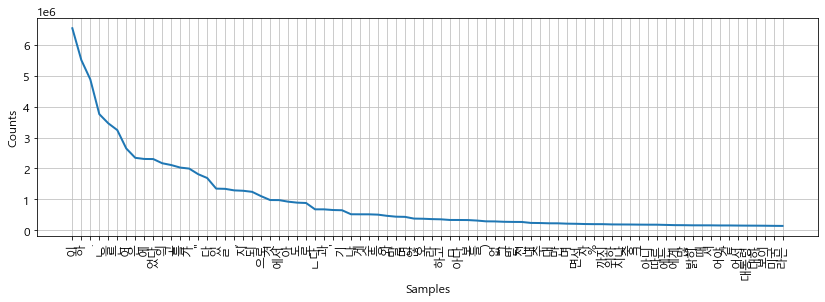

In [13]:
vocabs_body.plot(80)

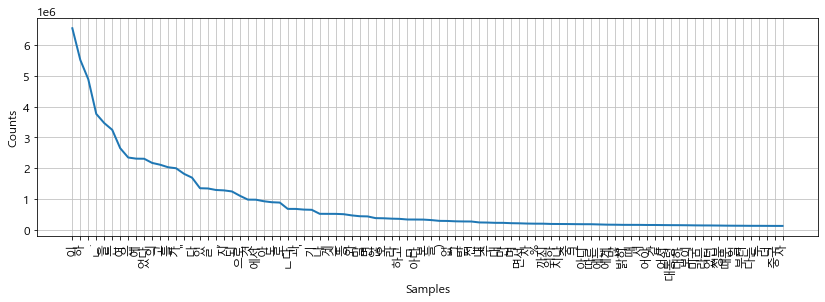

In [14]:
vocabs_body.plot(90)

In [15]:
stopwords_list1 = []
for _ in vocabs_body.most_common(75):
    stopwords_list1.append(_[0])

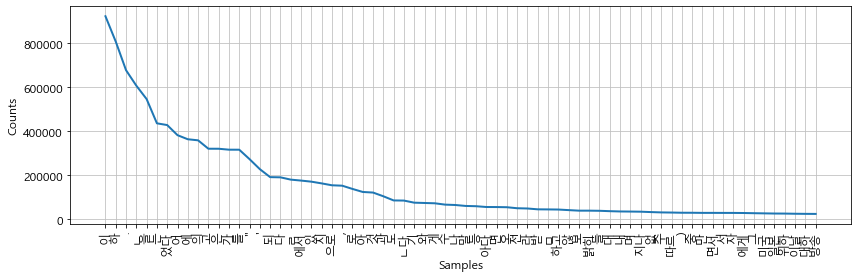

In [16]:
vocabs_summary.plot(70)

In [17]:
for _ in vocabs_summary.most_common(70):
    stopwords_list1.append(_[0])

In [18]:
stopwords2 = pd.read_csv('stopwords/stopwords_concat.csv')
stopwords_list2 = list(stopwords2['stopwords'].values)
len(stopwords_list2)

775

In [19]:
stopwords_list = stopwords_list1 + stopwords_list2
print(len(stopwords_list))
stopwords_list = list(set(stopwords_list))
print(len(stopwords_list))

920
700


In [20]:
def remove_stopwords(morphs_list):
    '''형태소(body_morphs / summary_morphs) 데이터를 받아 불용어를 처리하는 함수'''
    for _ in stopwords_list:
        if _ in morphs_list:
            morphs_list.remove(_)
    return morphs_list

In [21]:
news_tokenized.body_morphs = news_tokenized.body_morphs.apply(remove_stopwords)

In [22]:
news_tokenized.summary_morphs = news_tokenized.summary_morphs.apply(remove_stopwords)

In [23]:
news_tokenized['body_morphs']

0         [국무회의, 주재···체계적, 폭염대책, 주문, 최저임금, 명암···변화, 수용, ...
1         [대통령, 여름휴가, 노동자·소상공, 생각하길"김성태, 자유한국당, 원내대표, =,...
2         [노재천, 공보실장, 공식확인, 부적절···한미간, 공조"워싱턴포스트, 액화연료, ...
3         [김성태, 의원, 주장, 반박···지난, 정부, 에서도, 관련, 내용, 확인, 국방...
4         [안익산, 대표, 흔들, 종전선언, ?, 보도, 이해, 안익산, 북측, 수석대표, ...
                                ...                        
199995    [정부, 북한, 소형, 목선, 삼척항, 입항, 사건, 관련해, 관련, 군부대들, 경...
199996    [남북미, 정상회동, 뒷얘기, 밝혀···", 의전팀, 트럼프, 월경, 사전, 몰라"...
199997    [정치, 스스로, 통합, 정치, 못해···기독교,, 민주주의, 발전, 역하, 문, ...
199998    [선장, 처음, 엔, 북, 돌, 겠다, 었다가, 나중, 귀순, 의사, "", 북, ...
199999    [케어, 2주년, 성, 대회, 필요, 모든, 치료, 건보적용임기내, 보장률, 70,...
Name: body_morphs, Length: 200000, dtype: object

In [24]:
news_tokenized['summary_morphs']

0         [이낙연, 국무총리, 31일, 계속, 는, 폭염, 전기요금, 부담, 우려, 는, 관...
1         [김성태, 자유한국당, 원내대표, 31, 2004년, 노무현, 대통령, 탄핵, 당시...
2         [합동참모본부, 31, 북한, 이, 대륙간탄도미사일, 는, 정황, 을, 포착, 었다...
3         [국군기무사령부, 31일, 노무현, 대통령, 탄핵, 당시, 계엄령, 문건, 작성, ...
4         [북한, 이례적, 남북, 장성급, 군사회담, 먼저, 제의한데, 이, 이, 회담, 전...
                                ...                        
199995    [전국, 사흘, 첫, 지역사회, 감염자, 판정, 경기, 용인시, 거주, 29세, 남...
199996    [사상, 최초, 국민, 상대, 로, 가구당, 최대, 100만원, 긴급, 재난지원금,...
199997    [나흘, 국내, 지역사회, 신종, 코로나바이러스, 감염증(코로나19), 확진자, 방...
199998    [요새, '집콕', 라, 이, 뽀사먹, 재미, ㄴ데, 재난지원금, 사, 려고, 마트...
199999    [포르투갈, 출신, 세르지우, 멘드스, 씨(38), 식, 마니, ㄴ, 멘드스, 쓰,...
Name: summary_morphs, Length: 200000, dtype: object

## pickle로 저장 (normalized)

In [25]:
news_tokenized.to_pickle('../data/news_normalized.pickle')

In [ ]:
with open('../data/stopwords_list.txt', 'wb') as f:
    pickle.dump(stopwords_list, f)

# 기타 EDA

## 월별 groupby -> 워드클라우드